In [26]:
# general stuff
import numpy as np
import pandas as pd
import re
from datetime import datetime
# learning tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
# preprocessing tools
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import Imputer
#plotting tools
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
train_raw = pd.read_csv('data_sets/train.csv')

In [3]:
foo = train_raw.copy()
foo['Age'] = foo['Age'].fillna(foo['Age'].mean())

In [11]:
def preprocess_categorical(data,column):
    processed = data.copy()
    for status in data[column].unique():
        processed[column+'_'+str(status)] = (data[column]==status).astype(int)
    processed = processed.drop(column,axis=1)
    return processed
def deck_letter(x):
    if type(x) == str:
        return x[0]
    else:
        return np.nan
def preprocess_sex(data):
    data['gender'] = data['Sex'].apply(lambda x: int(x=='male'))
    return data
def preprocess_cabin(data):
    data['Cabin'] = data['Cabin'].apply(deck_letter)
    return data
def preprocess_last_name(data):
    re_string = '([A-Z]+[a-zA-Z].*),'
    data['Last_Name'] = data['Name'].apply(lambda x: (re.findall(re_string,x)+[''])[0])
    return data
def preprocess_same_last_name(data):
    data['Same_Last'] = data['Last_Name'].apply(lambda x: data['Last_Name'][data['Last_Name'] == x].count() - 1)
    return data
def preprocess_name(data):
    re_string = '.*, ([A-Z]+[a-zA-Z]*)\..*'
    data['Title'] = data['Name'].apply(lambda x: (re.findall(re_string,x)+[np.nan])[0])
    return data    
def preprocess_ticket(data):
    re_prefix = '(.*) .*'
    data['ticket_prefix'] = data['Ticket'].apply(lambda x: (re.findall(re_prefix,x)+[np.nan])[0])
    re_suffix = '[0-9]{2,}'
    data['ticket_suffix'] = data['Ticket'].apply(lambda x: float((re.findall(re_suffix,x)+[np.nan])[0]))
    return data
def preprocess(data,scale=True):
    data = preprocess_sex(data)
    data = preprocess_cabin(data)
    data = preprocess_name(data)
    data = preprocess_last_name(data)
    data = preprocess_same_last_name(data)
    data = preprocess_ticket(data)
    categorical = ['Embarked','Cabin','Title','ticket_prefix']
    iters = 0
    while iters < len(categorical):
        data = preprocess_categorical(data,categorical[iters])
        iters += 1
    data = data.fillna(data.median())
    ignore = ['Sex','PassengerId','Name','Last_Name','Ticket']
    data = data.drop(ignore,axis=1)
    return data

def preprocess_test(test,train):
    test = preprocess(test)
    for c_train in train.columns:
        if c_train not in test.columns:
            test[c_train] = 0
    for c_test in test.columns:
        if c_test not in train.columns:
            test = test.drop(c_test,axis=1)
    return test

In [13]:
train = preprocess(train_raw)

In [14]:
train_x = train.drop(['Survived'],axis=1)
train_y = train['Survived'].values
train_x.describe()

,Pclass,Age,SibSp,Parch,Fare,gender,Same_Last,ticket_suffix,Embarked_S,Embarked_C,...,ticket_prefix_A/S,ticket_prefix_SC/AH Basle,ticket_prefix_A/4,ticket_prefix_WE/P,ticket_prefix_S.W./PP,ticket_prefix_S.O./P.P.,ticket_prefix_F.C.,ticket_prefix_SOTON/O2,ticket_prefix_S.C./PARIS,ticket_prefix_C.A./SOTON
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.361582,0.523008,0.381594,32.204208,0.647587,0.882155,297745.874299,0.722783,0.188552,...,0.001122,0.001122,0.003367,0.002245,0.001122,0.003367,0.001122,0.002245,0.002245,0.001122
std,0.836071,13.019697,1.102743,0.806057,49.693429,0.477990,1.488014,656159.899304,0.447876,0.391372,...,0.033501,0.033501,0.057961,0.047351,0.033501,0.057961,0.033501,0.047351,0.047351,0.033501
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,541.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,14882.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000,112379.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000,347082.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,8.000000,3101317.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
clf = RandomForestClassifier(n_estimators=100,max_depth=len(train_x.columns))

In [16]:
clf.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=82, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Naive guess on test data without and cross validation

In [17]:
test_raw = pd.read_csv('data_sets/test.csv')

In [18]:
test_x = preprocess_test(test_raw,train_x)
print test_x.shape

(418, 82)


In [24]:
print sorted(test_x.columns) == sorted(train_x.columns)

True


In [25]:
predictions = clf.predict(test_x)
print predictions

[0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0
 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1
 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0]


In [28]:
time = datetime.now().isoformat()
np.savetxt('submissions/RF_naive_%s.csv'%time,
           np.c_[test_raw['PassengerId'],predictions],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

# Lets try a less Naive Guess

In [29]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=0)

In [ ]:
def cross_validation(train_x,train_y,p_range,k=50,parameter='n_estimators',silence=True,**kwargs):
    X_train, X_valid, Y_train, Y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=0)
    errors = []
    for p in p_range:
        kfold = KFold(len(X_train), n_folds=k,shuffle=True,random_state=0)
        error = 0
        params = dict({parameter:p},**kwargs)
        for train_index, val_index in kfold:
            x_train = X_train.iloc[train_index]
            y_train = Y_train[train_index]
            x_val = X_train.iloc[val_index]
            y_val = Y_train[val_index]
            clf = RandomForestClassifier(**params)
            clf.fit(x_train,y_train)
            predictions = clf.predict(x_val)
            err = np.sum((predictions != y_val),dtype=float)/len(y_val)
            error += err/k
        if silence != True:
            print p,':',error
        errors.append(error)
    best = p_range[np.argmin(errors)]
    return best,errors

In [ ]:
def parameter_search(train_x,train_y,parameters,k=50,max_cycles=3,step=1.):
    '''perform iterative search for best parameters
       initialize parameters with a guess of where the best should be
       like stochastic gradient decsent but for parameters
    '''
    iters = 0
    params = np.array(parameters.keys())
    values = np.array(parameters.values())
    while iters < max_cycles:
        print iters,':',dict(zip(params,values))
        for i in np.random.choice(np.arange(0,len(params)),len(params),replace=False):
            param,val = params[i],values[i]
            p_dict = {k:v for k,v in zip(params,values) if k != param}
            lower = np.logspace(0.5*np.log10(val),np.log10(val),3,dtype=int)
            if lower[0] <= 0:
                lower[0] = 1
            upper = np.logspace(np.log10(val),2*np.log10(val),3,dtype=int)
            param_range = np.unique(np.concatenate((lower,upper)))
            print param,':',val
            best_p,errors = cross_validation(train_x,train_y,param_range,parameter=param,**p_dict)
            p_diff = best_p - val
            values[i] = val + step*p_diff
        iters += 1
    return params,values

In [ ]:
p_dict = {'n_estimators':100,'max_depth':10,'min_samples_split':8}
parameter_search(train_x,train_y,p_dict,k=10,max_cycles=3,step=1.)

0 : {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 10}
n_estimators : 100
10 : 0.169166666667
31 : 0.17425
100 : 0.165166666667
316 : 0.163916666667
1000 : 0.16525
max_depth : 10
3 : 0.188833333333
5 : 0.175583333333
10 : 0.169083333333
17 : 0.173083333333
31 : 0.173083333333
min_samples_split : 8
2 : 0.165083333333
4 : 0.170416666667
7 : 0.16525
13 : 0.165166666667
22 : 0.177166666667
1 : {'n_estimators': 316, 'min_samples_split': 2, 'max_depth': 10}
min_samples_split : 2
1 : 0.169083333333
2 : 0.165166666667
n_estimators : 316
17 : 0.178166666667
74 : 0.162583333333
316 : 0.166333333333
1332

In [31]:
estim_range = np.logspace(0,3,4,dtype=int)
args = {'max_depth':len(train_x.columns)}
best_estimator,estim_errors = cross_validation(train_x,train_y,estim_range,k=50,parameter='n_estimators',**args)

1 : 0.267416666667
10 : 0.188
100 : 0.170333333333
1000 : 0.17975


In [32]:
depth_range = np.arange(1,len(train_x.columns))
args = {'n_estimators':best_estimator}
best_depth,depth_errors = cross_validation(train_x,train_y,depth_range,k=50,parameter='max_depth',**args)

1 : 0.306333333333
2 : 0.209833333333
3 : 0.19675
4 : 0.180916666667
5 : 0.179583333333
6 : 0.174333333333
7 : 0.159833333333
8 : 0.165166666667
9 : 0.169166666667
10 : 0.163666666667
11 : 0.162416666667
12 : 0.169083333333
13 : 0.17575
14 : 0.178333333333
15 : 0.177166666667
16 : 0.174416666667
17 : 0.1745
18 : 0.17175
19 : 0.169083333333
20 : 0.169083333333
21 : 0.175666666667
22 : 0.177083333333
23 : 0.179666666667
24 : 0.17575
25 : 0.178416666667
26 : 0.1745
27 : 0.177083333333
28 : 0.17175
29 : 0.17575
30 : 0.169083333333
31 : 0.174416666667
32 : 0.17175
33 : 0.187666666667
34 : 0.179666666667
35 : 0.178416666667
36 : 0.171666666667
37 : 0.178333333333
38 : 0.178416666667
39 : 0.17175
40 : 0.17575
41 : 0.17975
42 : 0.181
43 : 0.171833333333
44 : 0.177166666667
45 : 0.18775
46 : 0.170416666667
47 : 0.177
48 : 0.174416666667
49 : 0.169166666667
50 : 0.182416666667
51 : 0.173083333333
52 : 0.177
53 : 0.173083333333
54 : 0.178333333333
55 : 0.189083333333
56 : 0.178333333333
57 : 0.17

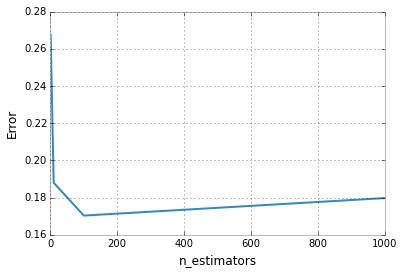

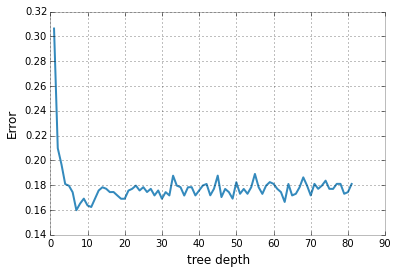

In [33]:
estim = plt.plot(estim_range,estim_errors,label='n trees')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.show()
depth = plt.plot(depth_range,depth_errors,label='depth')
plt.xlabel('tree depth')
plt.ylabel('Error')
plt.show()

In [42]:
min_samples_range = np.arange(2,100,2)
args = {'n_estimators':best_estimator,'max_depth':best_depth}
best_min_samples_split,split_errors = cross_validation(train_x,train_y,min_samples_range,k=50,parameter='min_samples_split',**args)

2 : 0.169
4 : 0.17025
6 : 0.1755
8 : 0.162333333333
10 : 0.169
12 : 0.1715
14 : 0.172916666667
16 : 0.17175
18 : 0.172833333333
20 : 0.173
22 : 0.174083333333
24 : 0.172916666667
26 : 0.168916666667
28 : 0.174333333333
30 : 0.17425
32 : 0.166416666667
34 : 0.172916666667
36 : 0.174333333333
38 : 0.175666666667
40 : 0.171583333333
42 : 0.181
44 : 0.174333333333
46 : 0.179583333333
48 : 0.174333333333
50 : 0.170333333333
52 : 0.17425
54 : 0.178333333333
56 : 0.174333333333
58 : 0.174333333333
60 : 0.182166666667
62 : 0.174333333333
64 : 0.177
66 : 0.174333333333
68 : 0.1755
70 : 0.178333333333
72 : 0.181
74 : 0.17825
76 : 0.17425
78 : 0.181
80 : 0.1835
82 : 0.18625
84 : 0.184833333333
86 : 0.182166666667
88 : 0.178166666667
90 : 0.186166666667
92 : 0.186166666667
94 : 0.186166666667
96 : 0.184833333333
98 : 0.184916666667


In [45]:
depth_range = np.arange(1,len(train_x.columns))
args = {'n_estimators':best_estimator,'min_samples_split':best_min_samples_split}
best_depth,depth_errors = cross_validation(train_x,train_y,depth_range,k=50,parameter='max_depth',**args)

1 : 0.294333333333
2 : 0.217833333333
3 : 0.190166666667
4 : 0.183416666667
5 : 0.170166666667
6 : 0.173
7 : 0.173
8 : 0.17175
9 : 0.167833333333
10 : 0.159833333333
11 : 0.170416666667
12 : 0.165083333333
13 : 0.167666666667
14 : 0.165083333333
15 : 0.161166666667
16 : 0.170333333333
17 : 0.172916666667
18 : 0.171666666667
19 : 0.1705
20 : 0.170416666667
21 : 0.171833333333
22 : 0.177
23 : 0.166416666667
24 : 0.174333333333
25 : 0.177
26 : 0.174333333333
27 : 0.178416666667
28 : 0.177
29 : 0.167833333333
30 : 0.175666666667
31 : 0.166416666667
32 : 0.171833333333
33 : 0.170333333333
34 : 0.174416666667
35 : 0.173166666667
36 : 0.171666666667
37 : 0.163666666667
38 : 0.177083333333
39 : 0.170333333333
40 : 0.16775
41 : 0.166416666667
42 : 0.17575
43 : 0.173083333333
44 : 0.169083333333
45 : 0.174333333333
46 : 0.173083333333
47 : 0.177
48 : 0.1665
49 : 0.170333333333
50 : 0.177
51 : 0.173083333333
52 : 0.17175
53 : 0.169083333333
54 : 0.169
55 : 0.170416666667
56 : 0.174333333333
57 : 

In [46]:
best_forest = RandomForestClassifier(n_estimators=best_estimator,max_depth=best_depth,min_samples_split=best_min_samples_split)
best_forest.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
predictions = best_forest.predict(X_valid)
error = np.sum(predictions!=Y_valid,dtype=float)/len(Y_valid)
print error

0.171641791045


In [48]:
best_forest.fit(train_x,train_y)
test_predictions = best_forest.predict(test_x)

In [50]:
time = datetime.now().isoformat()
np.savetxt('submissions/RF_lessnaive_%s.csv'%time,
           np.c_[test_raw['PassengerId'],test_predictions],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

# Slight improvement over logistic regression

# More cross validation may help

In [25]:
feature_range = range(1,len(train_x.columns)+1)+['auto','log2','sqrt']
args = {'max_depth':len(train_x.columns),'n_estimators':best_estimator}
best_feature,feature_errors = cross_validation(train_x,train_y,feature_range,k=50,parameter='max_features',**args)

1 : 0.194166666667
2 : 0.196833333333
3 : 0.196916666667
4 : 0.190166666667
5 : 0.188833333333
6 : 0.190083333333
7 : 0.196833333333
8 : 0.191666666667
9 : 0.186333333333
10 : 0.189
11 : 0.192916666667
12 : 0.179666666667
13 : 0.178416666667
14 : 0.182333333333
15 : 0.186416666667
16 : 0.187666666667
17 : 0.17975
18 : 0.182166666667
19 : 0.187666666667
20 : 0.182416666667
21 : 0.175833333333
22 : 0.17975
23 : 0.183666666667
24 : 0.18225
25 : 0.183583333333
26 : 0.178416666667
27 : 0.182416666667
28 : 0.181
29 : 0.177166666667
30 : 0.175833333333
31 : 0.177166666667
32 : 0.177083333333
33 : 0.178416666667
34 : 0.181083333333
35 : 0.173083333333
36 : 0.181166666667
37 : 0.182333333333
auto : 0.194166666667
log2 : 0.192833333333
sqrt : 0.1955


In [26]:
best_feature

35

In [27]:
best_forest = RandomForestClassifier(n_estimators=best_estimator,max_depth=best_depth,max_features=best_feature)
best_forest.fit(X_train,Y_train)
predictions = best_forest.predict(X_valid)
error = np.sum(predictions!=Y_valid,dtype=float)/len(Y_valid)
print error

0.171641791045


In [28]:
best_forest.fit(train_x,train_y)
test_predictions = best_forest.predict(test_x)

In [29]:
np.savetxt('titanic_RF_xv3.csv',
           np.c_[test_raw['PassengerId'],test_predictions],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

In [30]:
penalty_functions = ['gini','entropy']
args = {'max_depth':best_depth,'n_estimators':best_estimator,'max_features':best_feature}
best_function,function_errors = cross_validation(train_x,train_y,penalty_functions,k=50,parameter='criterion',**args)

gini : 0.15825
entropy : 0.16375


In [31]:
best_forest = RandomForestClassifier(n_estimators=best_estimator,
                                     max_depth=best_depth,
                                     max_features=best_feature,
                                     criterion=best_function)
best_forest.fit(X_train,Y_train)
predictions = best_forest.predict(X_valid)
error = np.sum(predictions!=Y_valid,dtype=float)/len(Y_valid)
print error

0.171641791045


In [32]:
best_forest.fit(train_x,train_y)
test_predictions = best_forest.predict(test_x)

In [33]:
np.savetxt('titanic_RF_xv4.csv',
           np.c_[test_raw['PassengerId'],test_predictions],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

#Begin Feature Engineering

### Trying single features as predictors

In [34]:
features = X_train.columns

In [36]:
single_feature_error = []
for feat in features:
    single_forest = RandomForestClassifier(n_estimators=best_estimator,
                                           criterion=best_function)
    single_forest.fit(X_train[[feat]],Y_train)
    predicts = single_forest.predict(X_valid[[feat]])
    err = np.sum(predicts!=Y_valid,dtype=float)/len(Y_valid)
    single_feature_error.append(err)
    print feat,':',err
best_1 = features[np.argmin(single_feature_error)]
print 'Best Single Feature:',best_1

Pclass : 0.298507462687
Age : 0.39552238806
SibSp : 0.365671641791
Parch : 0.380597014925
Fare : 0.313432835821
Sex_male : 0.223880597015
Sex_female : 0.223880597015
Embarked_S : 0.410447761194
Embarked_C : 0.373134328358
Embarked_Q : 0.410447761194
Embarked_nan : 0.410447761194
Cabin_nan : 0.410447761194
Cabin_C : 0.365671641791
Cabin_E : 0.402985074627
Cabin_G : 0.417910447761
Cabin_D : 0.365671641791
Cabin_A : 0.410447761194
Cabin_B : 0.365671641791
Cabin_F : 0.402985074627
Cabin_T : 0.410447761194
Title_Mr. : 0.268656716418
Title_Mrs. : 0.305970149254
Title_Miss. : 0.335820895522
Title_Master. : 0.402985074627
Title_Don. : 0.410447761194
Title_Rev. : 0.410447761194
Title_Dr. : 0.410447761194
Title_Mme. : 0.410447761194
Title_Ms. : 0.410447761194
Title_Major. : 0.410447761194
Title_Lady. : 0.410447761194
Title_Sir. : 0.410447761194
Title_Mlle. : 0.410447761194
Title_Col. : 0.417910447761
Title_Capt. : 0.410447761194
Title_the : 0.410447761194
Title_Jonkheer. : 0.410447761194
Best Si

In [37]:
features_2 = features.drop(best_1)

In [38]:
double_feature_error = []
for feat in features_2:
    if feat == best_1: continue
    double_forest = RandomForestClassifier(n_estimators=best_estimator,criterion=best_function)
    double_forest.fit(X_train[[best_1,feat]],Y_train)
    predicts = double_forest.predict(X_valid[[best_1,feat]])
    err = np.sum(predicts!=Y_valid,dtype=float)/len(Y_valid)
    double_feature_error.append(err)
    print feat,':',err
best_2 = features_2[np.argmin(double_feature_error)]
print 'Best Double Feature:',[best_1,best_2]

Pclass : 0.201492537313
Age : 0.216417910448
SibSp : 0.208955223881
Parch : 0.208955223881
Fare : 0.186567164179
Sex_female : 0.223880597015
Embarked_S : 0.223880597015
Embarked_C : 0.223880597015
Embarked_Q : 0.223880597015
Embarked_nan : 0.223880597015
Cabin_nan : 0.223880597015
Cabin_C : 0.223880597015
Cabin_E : 0.231343283582
Cabin_G : 0.223880597015
Cabin_D : 0.223880597015
Cabin_A : 0.223880597015
Cabin_B : 0.223880597015
Cabin_F : 0.223880597015
Cabin_T : 0.223880597015
Title_Mr. : 0.268656716418
Title_Mrs. : 0.223880597015
Title_Miss. : 0.223880597015
Title_Master. : 0.216417910448
Title_Don. : 0.223880597015
Title_Rev. : 0.223880597015
Title_Dr. : 0.223880597015
Title_Mme. : 0.223880597015
Title_Ms. : 0.223880597015
Title_Major. : 0.223880597015
Title_Lady. : 0.223880597015
Title_Sir. : 0.223880597015
Title_Mlle. : 0.223880597015
Title_Col. : 0.231343283582
Title_Capt. : 0.223880597015
Title_the : 0.223880597015
Title_Jonkheer. : 0.223880597015
Best Double Feature: ['Sex_male'

In [39]:
features_3 = features.drop([best_1,best_2])

In [40]:
triple_feature_error = []
for feat in features_3:
    if feat in [best_1,best_2]: continue
    triple_forest = RandomForestClassifier(n_estimators=best_estimator,criterion=best_function)
    triple_forest.fit(X_train[[best_1,best_2,feat]],Y_train)
    predicts = triple_forest.predict(X_valid[[best_1,best_2,feat]])
    err = np.sum(predicts!=Y_valid,dtype=float)/len(Y_valid)
    triple_feature_error.append(err)
    print feat,':',err
best_3 = features_3[np.argmin(triple_feature_error)]
print 'Best Triple Feature:',[best_1,best_2,best_3]

Pclass : 0.164179104478
Age : 0.223880597015
SibSp : 0.208955223881
Parch : 0.171641791045
Sex_female : 0.186567164179
Embarked_S : 0.201492537313
Embarked_C : 0.186567164179
Embarked_Q : 0.194029850746
Embarked_nan : 0.186567164179
Cabin_nan : 0.186567164179
Cabin_C : 0.186567164179
Cabin_E : 0.186567164179
Cabin_G : 0.186567164179
Cabin_D : 0.201492537313
Cabin_A : 0.186567164179
Cabin_B : 0.201492537313
Cabin_F : 0.171641791045
Cabin_T : 0.186567164179
Title_Mr. : 0.186567164179
Title_Mrs. : 0.246268656716
Title_Miss. : 0.238805970149
Title_Master. : 0.164179104478
Title_Don. : 0.186567164179
Title_Rev. : 0.186567164179
Title_Dr. : 0.194029850746
Title_Mme. : 0.186567164179
Title_Ms. : 0.186567164179
Title_Major. : 0.194029850746
Title_Lady. : 0.186567164179
Title_Sir. : 0.186567164179
Title_Mlle. : 0.194029850746
Title_Col. : 0.186567164179
Title_Capt. : 0.194029850746
Title_the : 0.186567164179
Title_Jonkheer. : 0.194029850746
Best Triple Feature: ['Sex_male', 'Fare', 'Pclass']


In [41]:
three_forest = RandomForestClassifier(n_estimators=best_estimator,criterion=best_function)
three_forest.fit(train_x[[best_1,best_2,best_3]],train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
test_predictions_3 = three_forest.predict(test_x[[best_1,best_2,best_3]])
np.savetxt('titanic_RF_three.csv',
           np.c_[test_raw['PassengerId'],test_predictions_3],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

In [167]:
print np.sum(test_predictions_3 != test_predictions)

46
